In [ ]:
import importlib
import numpy as np
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches

import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.modeling.models import Gaussian2D
from astropy.visualization import quantity_support
from astropy.visualization import wcsaxes
from astropy.wcs import WCS
from astropy.coordinates import AltAz
from astropy.coordinates import SkyOffsetFrame
import astropy.constants as const
from astropy.table import Table

# Assume these are defined elsewhere in your script
#from baseband_analysis.core.bbdata import BBData
#from baseband_analysis.core.dedispersion import delay_across_the_band
#from baseband_analysis.core.bbdata import BBData
#from baseband_analysis.analysis.snr import get_snr
#from baseband_analysis.core.dedispersion import incoherent_dedisp, coherent_dedisp, get_freq

# Dispersion constant in MHz^2 pc^-1 cm^3 s

from numpy.typing import NDArray
import numpy as np

import toa_utilities
importlib.reload(toa_utilities)
from toa_utilities import downsample_time, measure_fwhm, calculate_dm_timing_error, clean_and_serialize_dict, append_to_json

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['cmr10']
rcParams['font.size'] = 28
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = False
#rcParams['text.usetex'] = True


ModuleNotFoundError: No module named 'baseband_analysis'

In [ ]:
# Read the FITS table (auto-detects the table HDU)
bprops = Table.read('bursts.fits')

# 2) Select the row(s) where name == 'zach'
bname = 'zach'
burst = bprops[bprops['name'] == bname]

# 3) Inspect the result
print(burst)               # prints a tiny table with all columns for 'zach'
print(burst['chime_id'])   # e.g. ['210456524']

# 4) If you want the first match as a Row object
burst = burst[0]
print(burst['dm'], burst['dsa_mjd'], burst['time_limits'])

name             loc               chime_id ...    rfi_limits   fill_wfall_no
---- ---------------------------- --------- ... --------------- -------------
zach 20h40m47.886s +72d52m56.378s 210456524 ... 10000 .. -10000             1
 chime_id
---------
210456524
262.368 59617.80850364017 [    0 10000]


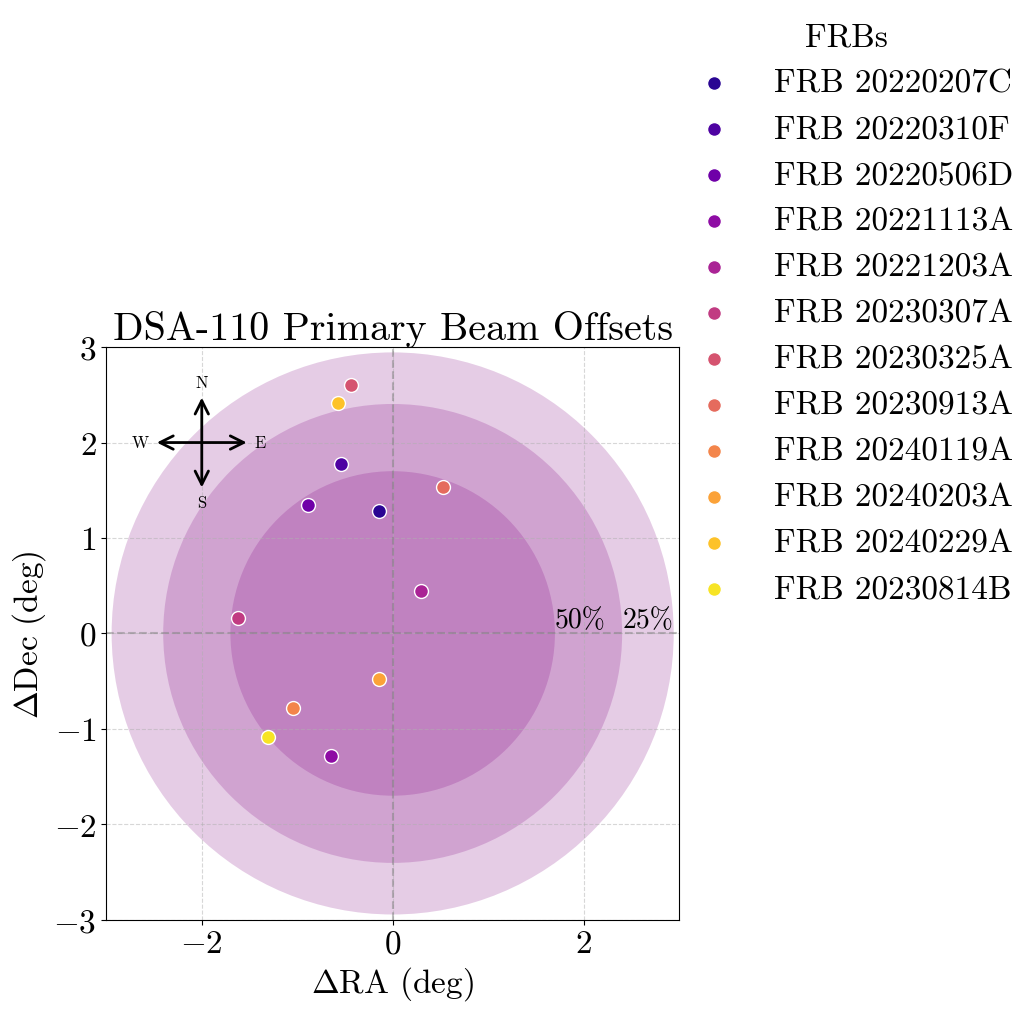

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units as u
from matplotlib.patches import Circle

# 1) Inputs
names = np.array([
    'zach', 'whitney', 'oran', 'isha', 'wilhelm', 'phineas',
    'freya', 'johndoeII', 'hamilton', 'mahi', 'chromatica', 'casey', 'reginald'
])

tns_names = np.array(['FRB 20220207C',
                    'FRB 20220310F',
                    'FRB 20220506D',
                    'FRB 20221113A',
                    'FRB 20221203A',
                    'FRB 20230307A',
                    'FRB 20230325A',
                    'FRB 20230913A', 
                    'FRB 20240119A',
                    'FRB 20240203A',
                    'FRB 20240229A',
                    'FRB 20230814B',
                    'FRB Reginald'])

localizations = [
    '20h40m47.886s +72d52m56.378s',
    '08h58m52.92s  +73d29m27.0s',
    '21h12m10.760s +72d49m38.20s',
    '04h45m38.64s  +70d18m26.6s',
    '21h00m31.09s  +72d02m15.22s',
    '11h51m07.52s  +71d41m44.3s',
    '05h52m45.12s  +74d12m01.7s',
    '22h23m53.94s +73d01m33.26s',
    '20h20m08.92s +70d47m33.96s',
    '02h39m03.96s +71d01m04.3s',
    '20h50m28.59s +73d54m00.0s',
    '11h19m56.05s +70d40m34.4s',
    '20h31m06.38s, +53d50m56.4s'
]

dsa_mjds = np.array([
    59617.808503640170, 59648.241720744330, 59705.597012923540,
    59896.386510976576, 59916.001750895850, 60010.378857718510,
    60028.071690572535, 60170.360926755560, 60200.207158083010,
    60331.104280012750, 60343.831821948540, 60369.370952243030, 60942.172498155225
    
])

beam_decs = np.array([
    71.6, 71.72, 71.5, 71.6, 71.6, 71.6,
    71.6, 71.5, 71.6, 71.5, 71.5, 71.8, 53.5
])

# 2) Compute beam-center RAs from the local sidereal time at OVRO
ovro = EarthLocation.of_site('OVRO')
times = Time(dsa_mjds, format='mjd', scale='utc')
beam_ras = times.sidereal_time('apparent', longitude=ovro.lon).deg

# 3) Build SkyCoord arrays
burst_coords = SkyCoord(localizations, frame='icrs')
beam_centers = SkyCoord(ra=beam_ras*u.deg, dec=beam_decs*u.deg, frame='icrs')

# 4) Calculate offsets
# Method 1: Using spherical_offsets_to 
#dra_sph, ddec_sph = burst_coords.spherical_offsets_to(beam_centers)
dra_sph, ddec_sph = beam_centers.spherical_offsets_to(burst_coords)
dra = dra_sph.deg  # These are already properly projected
ddec = ddec_sph.deg

# Alternative Method 2: Manual calculation with cos(dec) correction
# dra_raw = (burst_coords.ra - beam_centers.ra).deg
# # Wrap to [-180, 180]
# dra_raw = ((dra_raw + 180) % 360) - 180
# # Apply cos(dec) correction using average declination
# avg_dec = (burst_coords.dec.rad + beam_centers.dec.rad) / 2
# dra_manual = dra_raw * np.cos(avg_dec)
# ddec_manual = (burst_coords.dec - beam_centers.dec).deg

# 5) Plot
fig, ax = plt.subplots(figsize=(11, 11))

# Beam-response circles (Gaussian)
fwhm = 3.4  # degrees
for frac, lbl in [(0.5, '50%'), (0.25, '25%'), (0.125,'')]:
    r = np.sqrt(-np.log(frac)/(4*np.log(2))) * fwhm
    circ = Circle((0,0), r, edgecolor='none', facecolor='purple',
                  alpha=0.2)
    ax.add_patch(circ)
    ax.text(r, 0, lbl, ha='left', va='bottom', fontsize=20)

# Draw concentric circles for beam response
#for r in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
#    circ = Circle((0, 0), radius=r,
#                  edgecolor='none',
#                  facecolor='purple',
#                  alpha=0.2)
#    ax.add_patch(circ)

# Color map for points
colors = plt.get_cmap('plasma')(np.linspace(0.05, 0.95, len(names)))

# Scatter each burst
for x, y, name, c in zip(dra, ddec, tns_names, colors):
    #print(name, x, y)
    ax.scatter(x, y,
               color=c,
               edgecolor='white',
               s=100,
               label=name,
               zorder=5)

# Add compass rose in upper left
compass_x = -2.  # Position in upper left
compass_y = 2.
compass_length = 0.5  # Length of arrows from center

# Create cross-haired arrows
# North-South arrow
ax.annotate('', xy=(compass_x, compass_y + compass_length), 
            xytext=(compass_x, compass_y - compass_length),
            arrowprops=dict(arrowstyle='<->', lw=2, color='black'))

# East-West arrow  
ax.annotate('', xy=(compass_x + compass_length, compass_y), 
            xytext=(compass_x - compass_length, compass_y),
            arrowprops=dict(arrowstyle='<->', lw=2, color='black'))

# Add labels at arrow tips
ax.text(compass_x, compass_y + compass_length + 0.05, 'N', 
        ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text(compass_x, compass_y - compass_length - 0.05, 'S', 
        ha='center', va='top', fontsize=12, fontweight='bold')
ax.text(compass_x + compass_length + 0.05, compass_y, 'E', 
        ha='left', va='center', fontsize=12, fontweight='bold')
ax.text(compass_x - compass_length - 0.05, compass_y, 'W', 
        ha='right', va='center', fontsize=12, fontweight='bold')

# Add cross-hairs at origin
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Formatting
ax.legend(frameon = False, bbox_to_anchor=[0.95, 0.5, 0.5, 0.5], 
          title='FRBs', ncol=1, framealpha=0.9)
ax.set_aspect('equal', 'box')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel(r'$\Delta$RA (deg)')
ax.set_ylabel(r'$\Delta$Dec (deg)')
ax.set_title('DSA-110 Primary Beam Offsets')
ax.grid(True, ls='--', alpha=0.5)

# Add annotations for beam response levels
#ax.text(0.5, 0.1, r'$\bf{50\%}$', ha='left', va='center', fontsize=16, alpha=0.85)
#ax.text(1.0, 0.1, r'$\bf{25\%}$', ha='left', va='center', fontsize=16, alpha=0.85)
#ax.text(1.5, 0.1, r'$\bf{12.5\%}$', ha='left', va='center', fontsize=16, alpha=0.85)
#
plt.tight_layout()
plt.show()

# Print some diagnostics
#print("Sample offsets (first 3 FRBs):")
#for i in range(3):
#    print(f"{names[i]}: ΔRA = {dra[i]:.3f}°, ΔDec = {ddec[i]:.3f}°")
#    print(f"  Distance from beam center: {np.sqrt(dra[i]**2 + ddec[i]**2):.3f}°")

In [242]:
print("Debugging beam center calculations:")
print("-" * 60)
for i in range(len(names)):
    burst_ra = burst_coords[i].ra.deg
    beam_ra = beam_ras[i]
    ra_diff = burst_ra - beam_ra
    if ra_diff > 180:
        ra_diff -= 360
    elif ra_diff < -180:
        ra_diff += 360
    
    print(f"{names[i]:12s}: Burst RA={burst_ra:7.2f}°, Beam RA={beam_ra:7.2f}°")
    print(f"              RA diff={ra_diff:7.2f}°, Dec diff={burst_coords[i].dec.deg - beam_decs[i]:5.2f}°")
    print()

Debugging beam center calculations:
------------------------------------------------------------
zach        : Burst RA= 310.20°, Beam RA= 310.67°
              RA diff=  -0.47°, Dec diff= 1.28°

whitney     : Burst RA= 134.72°, Beam RA= 136.62°
              RA diff=  -1.90°, Dec diff= 1.77°

oran        : Burst RA= 318.04°, Beam RA= 321.06°
              RA diff=  -3.02°, Dec diff= 1.33°

isha        : Burst RA=  71.41°, Beam RA=  73.33°
              RA diff=  -1.92°, Dec diff=-1.29°

wilhelm     : Burst RA= 315.13°, Beam RA= 314.15°
              RA diff=   0.98°, Dec diff= 0.44°

phineas     : Burst RA= 177.78°, Beam RA= 182.93°
              RA diff=  -5.15°, Dec diff= 0.10°

freya       : Burst RA=  88.19°, Beam RA=  89.79°
              RA diff=  -1.61°, Dec diff= 2.60°

johndoeII   : Burst RA= 335.97°, Beam RA= 334.17°
              RA diff=   1.81°, Dec diff= 1.53°

hamilton    : Burst RA= 305.04°, Beam RA= 308.23°
              RA diff=  -3.19°, Dec diff=-0.81°

mahi        

In [243]:
# Observatory locations
dsa110 = EarthLocation.of_site('ovro')  # DSA-110 at OVRO
chime = EarthLocation.of_site('drao')   # CHIME at DRAO

# Calculate baseline vector (in ECEF coordinates)
# Get the ITRS (Earth-fixed) coordinates
dsa110_itrs = dsa110.get_itrs()
chime_itrs = chime.get_itrs()

# Calculate baseline in meters
baseline_x = (chime_itrs.x - dsa110_itrs.x).to(u.m).value
baseline_y = (chime_itrs.y - dsa110_itrs.y).to(u.m).value
baseline_z = (chime_itrs.z - dsa110_itrs.z).to(u.m).value
baseline_xyz = np.array([baseline_x, baseline_y, baseline_z])

# Create grid for heatmap
ra_grid = np.linspace(0, 360, 90)
dec_grid = np.linspace(-90, 90, 30)
RA_grid, DEC_grid = np.meshgrid(ra_grid, dec_grid)

# Calculate time delays for grid
delays_grid = np.zeros_like(RA_grid)

for i in range(len(dec_grid)):
    for j in range(len(ra_grid)):
        # Create SkyCoord for this grid point
        coord = SkyCoord(ra=ra_grid[j]*u.deg, dec=dec_grid[i]*u.deg, frame='icrs')
        
        # Convert to unit vector pointing to source
        # In ICRS frame (approximately aligned with ECEF for our purposes)
        ra_rad = coord.ra.rad
        dec_rad = coord.dec.rad
        source_vec = np.array([
            np.cos(dec_rad) * np.cos(ra_rad),
            np.cos(dec_rad) * np.sin(ra_rad),
            np.sin(dec_rad)
        ])
        
        # Calculate geometric delay: delay = baseline . source / c
        delay_m = np.dot(baseline_xyz, source_vec)
        delay_ms = delay_m / const.c.value * 1e3  # Convert to microseconds
        delays_grid[i, j] = delay_ms


<SkyCoord (ICRS): (ra, dec) in deg
    (310.199525, 72.88232722)>
<SkyCoord (ICRS): (ra, dec) in deg
    (134.7205, 73.49083333)>
<SkyCoord (ICRS): (ra, dec) in deg
    (318.04483333, 72.82727778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (71.411, 70.30738889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (315.12954167, 72.03756111)>
<SkyCoord (ICRS): (ra, dec) in deg
    (177.78133333, 71.69563889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (88.188, 74.20047222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (335.97475, 73.02590556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (305.03716667, 70.79276667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (39.7665, 71.01786111)>
<SkyCoord (ICRS): (ra, dec) in deg
    (312.619125, 73.9)>
<SkyCoord (ICRS): (ra, dec) in deg
    (169.98354167, 70.67622222)>


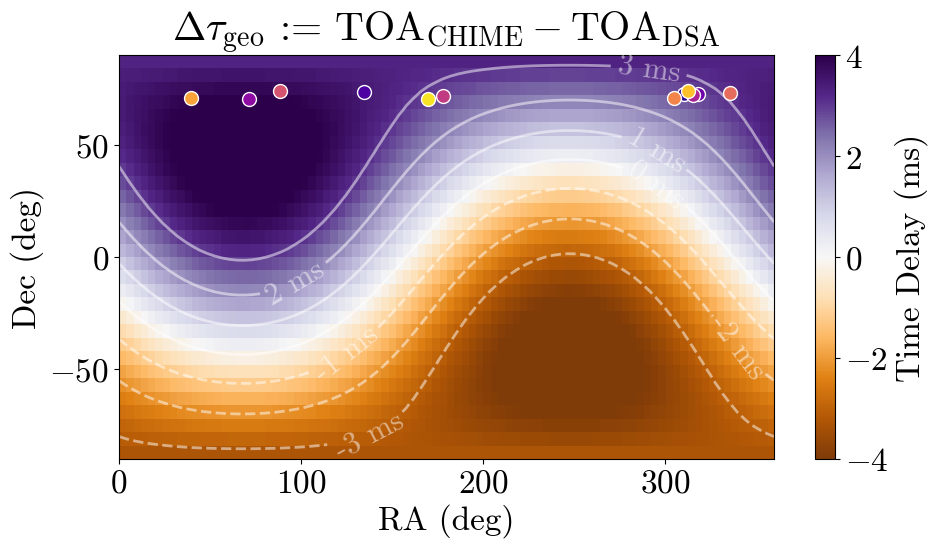

In [244]:
# Create figure
fig, ax = plt.subplots(figsize=(10,6))

# Plot heatmap
im = ax.imshow(delays_grid, extent=[0, 360, -90, 90], 
               origin='lower', aspect='auto', cmap='PuOr',
               vmin=-4, vmax=4)  # Adjust range as needed

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Time Delay (ms)')

# Convert burst coordinates and plot
burst_coords = SkyCoord(localizations, frame='icrs')
burst_ras = burst_coords.ra.deg
burst_decs = burst_coords.dec.deg

# Calculate actual delays for bursts
burst_delays = []
for coord in burst_coords:
    print(coord)
    ra_rad = coord.ra.rad
    dec_rad = coord.dec.rad
    source_vec = np.array([
        np.cos(dec_rad) * np.cos(ra_rad),
        np.cos(dec_rad) * np.sin(ra_rad),
        np.sin(dec_rad)
    ])
    delay_m = np.dot(baseline_xyz, source_vec)
    delay_ms = delay_m / const.c.value * 1e3
    burst_delays.append(delay_ms)

# Use consistent colors from the plasma colormap
colors = plt.get_cmap('plasma')(np.linspace(0.05, 0.95, len(names)))

# Plot bursts
for i, (ra, dec, name, delay) in enumerate(zip(burst_ras, burst_decs, names, burst_delays)):
    ax.scatter(ra, dec, color=colors[i], edgecolor='white', 
               s=100, label=f'{name} ({delay:.0f} ms)', zorder=5)

# Formatting
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(r'$\Delta \tau_\mathregular{geo}}$ := $\mathregular{TOA_{CHIME} - TOA_{DSA}}$')
#ax.grid(False, alpha=0.3, color='white', linewidth=0.5)

# Add legend
#ax.legend(frameon = False, bbox_to_anchor=(1.15, 0.5), ncol = 2, loc='center left', 
#          title=r'FRBs ($\Delta$TOA)', fontsize='small', framealpha=0.9)

# Add contour lines for specific delay values
contour_levels = [-3, -2, -1, 0, 1, 2, 3]
CS = ax.contour(RA_grid, DEC_grid, delays_grid, levels=contour_levels, 
                colors='white', alpha=0.5, linewidths=2)
ax.clabel(CS, inline=True, fontsize=22, fmt='%d ms')

plt.tight_layout()
plt.show()

# Print burst delays
#print("Burst time delays (CHIME - DSA-110):")
#print(f"Baseline length: {np.linalg.norm(baseline_xyz)/1000:.1f} km")
#print("-" * 40)
#for name, delay in zip(names, burst_delays):
#    print(f"{name:12s}: {delay:6.1f} ms")

In [245]:
#import json
#
## 1) Load your original list
#with open('toa_crossmatch_results.json', 'r') as f:
#    bursts = json.load(f)
#
## 2) Build a new dict, using 'chime_id' (or any other field) as the key
##    Note: JSON object keys must be strings, so we cast to str.
#by_id = {}
#for i in range(len(names)):
#    key = str(names[i])
#    by_id[key] = bursts[i]
#
## 3) (Optional) If you don’t want 'chime_id' repeated inside each entry,
##    you can pop it out—but you said you want to keep it, so we’ll skip that.
#
## 4) Write the new JSON
#with open('toa_by_id.json', 'w') as f:
#    json.dump(by_id, f, indent=2)
#
#print("Wrote", len(by_id), "entries to toa_by_id.json")
#

zach
whitney
oran
isha
wilhelm
phineas
freya
johndoeII
hamilton
mahi
chromatica
casey
Combined figure saved to toa_combined_stacked_plots.pdf


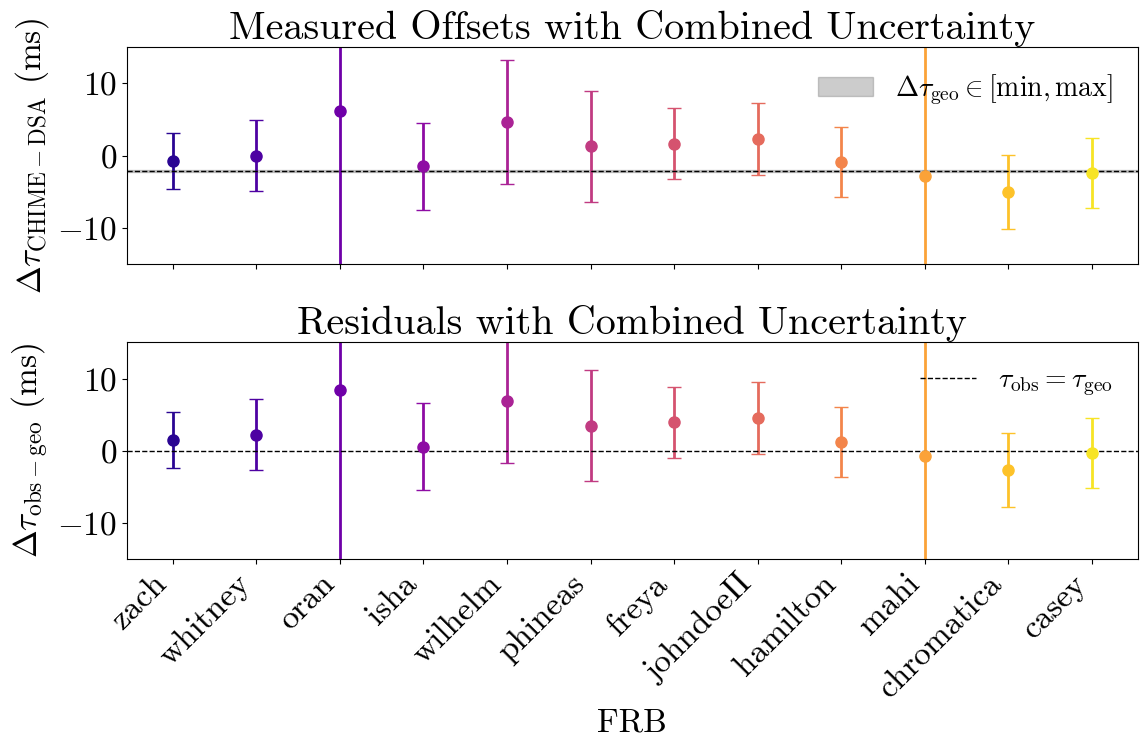

In [ ]:
#import json
#import matplotlib.pyplot as plt
#import numpy as np
#
#def create_stacked_plots(json_filename, output_image_filename):
#    """
#    Reads FRB analysis results from a JSON file and creates a stacked figure:
#      Top:    Measured TOA offsets with full errors vs. FRB
#      Bottom: Residuals (measured – geometric) with full errors vs. FRB
#
#    Parameters
#    ----------
#    json_filename : str
#        Path to the input JSON file.
#    output_image_filename : str
#        Path to save the combined figure.
#    """
#    # Load data
#    with open(json_filename, 'r') as f:
#        results_data = json.load(f)
#
#    # Prepare lists
#    labels    = []
#    offsets   = []
#    geo_delays= []
#    residuals = []
#    errors    = []
#
#    # Extract
#    for name, burst in results_data.items():
#        #name = burst.get('name', f"FRB{len(labels)}")
#        print(name)
#        labels.append(name)
#
#        m = burst['measured_offset_ms']
#        g = burst['geometric_delay_ms']
#        dm_err   = burst['combined_dm_uncertainty_ms']
#        stat_err = burst['fwhm_ms']
#        tot_err  = np.sqrt(dm_err**2 + stat_err**2)
#
#        offsets.append(m)
#        geo_delays.append(g)
#        residuals.append(m - g)
#        errors.append(tot_err)
#
#    if not labels:
#        raise ValueError("No bursts found in JSON.")
#
#    # Set up figure with 2 rows, shared x-axis
#    fig, (ax1, ax2) = plt.subplots(
#        nrows=2, ncols=1,
#        figsize=(12, 8),
#        sharex=True,
#        gridspec_kw={'height_ratios': [1, 1]}
#    )
#
#    x = np.arange(len(labels))
#    cmap = plt.get_cmap('plasma')
#    colors = cmap(np.linspace(0.05, 0.95, len(labels)))
#
#    # --- Top panel: Offsets with full errors ---
#    for i, (xi, off, err, c) in enumerate(zip(x, offsets, errors, colors)):
#        # You can adjust the error‐multiplier per point if desired
#        err_mult = 1.5 if i == 0 else (3.5 if i == 4 else 2.0)
#        ax1.errorbar(
#            xi, off, yerr=err * err_mult,
#            fmt='o', markersize=8, color=c,
#            linewidth=2, capsize=5
#        )
#    # Shade the geo‐delay range and mean line
#    ax1.axhline(np.mean(geo_delays), color='k', linestyle='--', linewidth=1)
#    ax1.axhspan(
#        np.min(geo_delays), np.max(geo_delays),
#        color='grey', alpha=0.4,
#        label=r'$\Delta\tau_{\rm geo}\in[\min,\max]$'
#    )
#    ax1.set_ylabel(r'$\Delta\tau_{\rm CHIME-DSA}$ (ms)')
#    ax1.legend(frameon=False, fontsize='small', loc='upper right')
#    ax1.set_title('Measured Offsets with Combined Uncertainty')
#
#    # --- Bottom panel: Residuals with full errors ---
#    for i, (xi, res, err, c) in enumerate(zip(x, residuals, errors, colors)):
#        err_mult = 1.5 if i == 0 else (3.5 if i == 4 else 2.0)
#        ax2.errorbar(
#            xi, res, yerr=err * err_mult,
#            fmt='o', markersize=8, color=c,
#            linewidth=2, capsize=5
#        )
#    ax2.axhline(0, color='k', linestyle='--', linewidth=1,
#                label=r'$\tau_{\rm obs} = \tau_{\rm geo}$')
#    ax2.set_ylabel(r'$\Delta\tau_{\rm obs-geo}$ (ms)')
#    ax2.set_xlabel('FRB')
#    ax2.legend(frameon=False, fontsize='small', loc='upper right')
#    ax2.set_title('Residuals with Combined Uncertainty')
#
#    # Final tweaks
#    ax2.set_xticks(x)
#    ax2.set_xticklabels(labels, rotation=45, ha='right')
#    ax1.set_ylim(-15, 15)
#    ax2.set_ylim(-15, 15)
#    fig.tight_layout()
#
#    # Save and show
#    plt.savefig(output_image_filename)
#    print(f"Combined figure saved to {output_image_filename}")
#    plt.show()
#
#
## Example usage:
#json_file = 'toa_crossmatch_results.json'
#output_pdf = 'toa_combined_stacked_plots.pdf'
#create_stacked_plots(json_file, output_pdf)
#

Plot successfully saved to toa_offsets_plot_with_full_errors.pdf


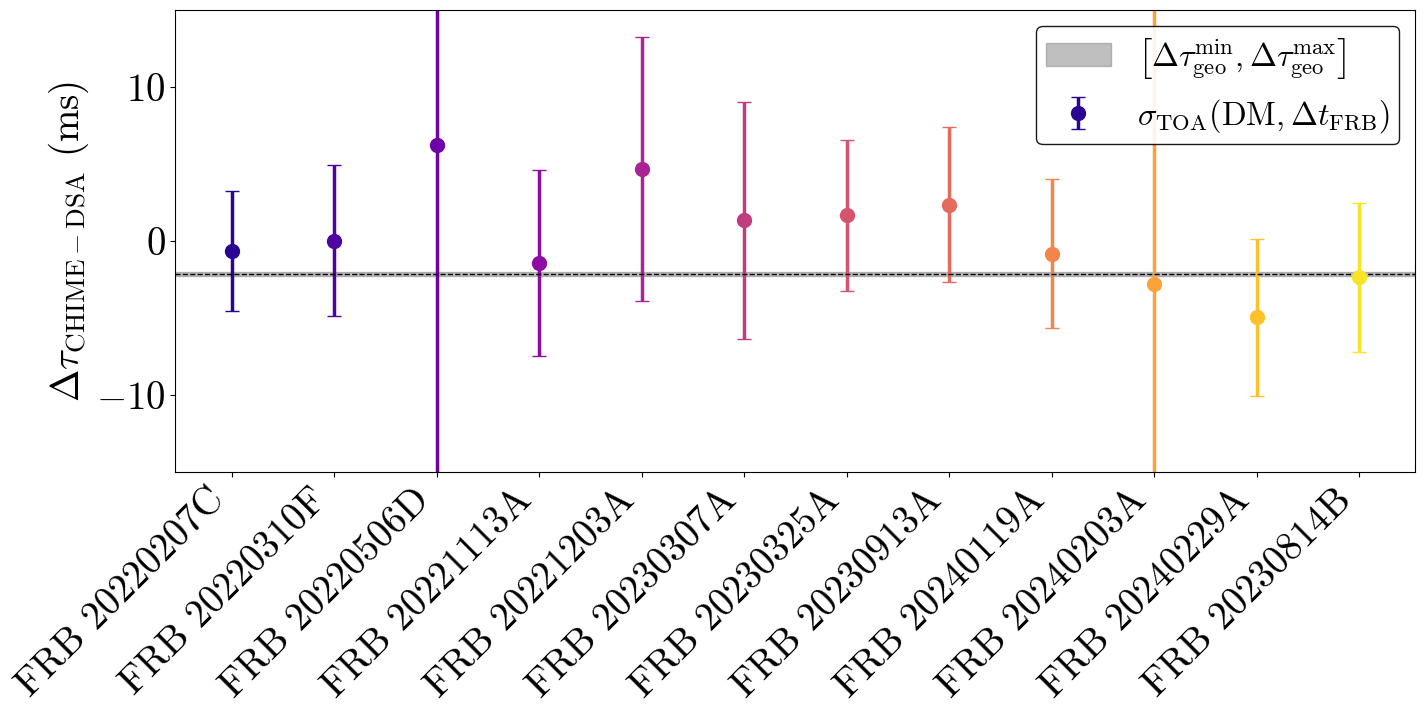

In [254]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def create_residual_plot_with_full_errors(json_filename, output_image_filename):
    """
    Reads FRB analysis results from a JSON file and creates a
    residual plot of the TOA offsets, including FWHM in the error.

    Parameters
    ----------
    json_filename : str
        The path to the input JSON file.
    output_image_filename : str
        The path to save the output plot image.
    """
    #try:
    with open(json_filename, 'r') as f:
        results_data = json.load(f)
    #except FileNotFoundError:
    #    print(f"Error: The file '{json_filename}' was not found.")
    #    return
    #except json.JSONDecodeError:
    #    print(f"Error: Could not decode JSON from '{json_filename}'.")
    #    return

    # --- Extract data for plotting ---
    burst_labels = []
    #residuals = []
    offsets = []
    geo_offsets = []
    errors = []
    colors = plt.get_cmap('plasma')(np.linspace(0.25, 0.75, len(names)))
    
    tns_names = np.array(['FRB 20220207C',
                        'FRB 20220310F',
                        'FRB 20220506D',
                        'FRB 20221113A',
                        'FRB 20221203A',
                        'FRB 20230307A',
                        'FRB 20230325A',
                        'FRB 20230913A', 
                        'FRB 20240119A',
                        'FRB 20240203A',
                        'FRB 20240229A',
                        'FRB 20230814B'])
    
    i = 0
    for name, burst in results_data.items():
        # Check for all required keys for this analysis
        #required_keys = ['name', 'measured_offset_ms', 'geometric_delay_ms', 'combined_dm_uncertainty_ms', 'fwhm_ms']
        #if not all(key in burst for key in required_keys):
        #    print(f"Skipping burst {burst.get('name', 'Unknown')} due to missing data keys.")
        #    continue
            
        # Use the 'name' field for labels
        burst_labels.append(tns_names[i])
        i += 1
        
        # Calculate the residual: (Measured Offset) - (Predicted Geometric Delay)
        #residual = burst['measured_offset_ms'] - burst['geometric_delay_ms']
        #residuals.append(residual)
        offset = burst['measured_offset_ms']
        offsets.append(offset)
        
        geo_offset = burst['geometric_delay_ms']
        geo_offsets.append(geo_offset)
        
        # --- Combine error sources in quadrature ---
        # Systematic error from DM uncertainty
        dm_error = burst['combined_dm_uncertainty_ms']
        
        # Statistical error from burst width (FWHM / S/N).
        # Here we assume 'fwhm_ms' represents this statistical error component.
        # If you have S/N, you would calculate: stat_error = burst['fwhm_ms'] / burst['snr']
        stat_error = burst['fwhm_ms']
        
        total_error = np.sqrt(dm_error**2 + stat_error**2)
        errors.append(total_error)

    if not offsets:
        print("No valid data found to plot.")
        return

    # --- Create the Plot ---
    fig, ax = plt.subplots(figsize=(16,6))

    # Create an index for the x-axis positions
    x_pos = np.arange(len(burst_labels))

    # Plot the data points with combined error bars
    colors = plt.get_cmap('plasma')(np.linspace(0.05, 0.95, len(names)))
    ax.errorbar(
            x_pos[0], offsets[0], yerr=errors[0]*1.5,
            fmt='o',
            markersize=10,
            color=colors[0],               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
            label = r'$\sigma_{\mathrm{TOA}} (\mathrm{DM}, \Delta t_{\mathrm{FRB}})$' #r'$\sqrt{\sigma_{\mathrm{TOA, DM}}^2+\sigma_W^2}$'
        )
    for x, y, err, c in zip(x_pos[1:4], offsets[1:4], errors[1:4], colors[1:4]):
        ax.errorbar(
            x, y, yerr=err*2,
            fmt='o',
            markersize=10,
            color=c,               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
        )
    ax.errorbar(
            x_pos[4], offsets[4], yerr=errors[4]*3.5,
            fmt='o',
            markersize=10,
            color=colors[4],               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
        )
    for x, y, err, c in zip(x_pos[5:], offsets[5:], errors[5:], colors[5:]):
        ax.errorbar(
            x, y, yerr=err*2,
            fmt='o',
            markersize=10,
            color=c,             # marker and errorbar color
            linewidth=2.5,
            capsize=5,
        )

    # Add a horizontal line at y=0 for reference (perfect agreement)
    ax.axhline(np.mean(geo_offsets), color='k', linestyle='--', linewidth=1) #, label=r'$\Delta \tau_\mathregular{geo}$')
    ax.axhspan(np.min(geo_offsets), np.max(geo_offsets), color = 'grey' , alpha = 0.5, label=r'$\left[\Delta \tau_{\mathregular {geo }}^{\min }, \Delta \tau_{\mathregular {geo }}^{\max }\right]$')
    
    
    # --- Formatting and Labels ---
    ax.set_xticks(x_pos)
    ax.set_xticklabels(burst_labels, rotation=45, ha='right')
    
    ax.set_ylabel(r'$\Delta \tau_\mathregular{CHIME - DSA}}$ (ms)')
    #ax.set_xlabel('FRB')
    #ax.set_title('TOAResiduals with Combined Uncertainty (CHIME vs. DSA-110)')
    
    #ax.legend(frameon=False, loc='upper right') #bbox_to_anchor=[0.905, 0.5, 0.5, 0.5])
    ax.legend(loc = 'upper right',frameon=True,          # draw the legend patch
    fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
    framealpha=0.9,        # overall opacity of the legend background
    facecolor='white',     # background color
    edgecolor='black',     # border color
    borderpad=0.3,
    fontsize='small')
    #ax.grid(axis='y', linewidth=5, linestyle='-', alpha=0.1, c = 'purple')
    ax.set_ylim(-15, 15)
    
    # Ensure layout is tight
    #plt.tight_layout()

    # Save the figure
    plt.savefig(output_image_filename)
    print(f"Plot successfully saved to {output_image_filename}")
    plt.show()


# Now, run the plotting function on the new JSON file
json_file = 'toa_crossmatch_results.json'
output_image = 'toa_offsets_plot_with_full_errors.pdf'
create_residual_plot_with_full_errors(json_file, output_image)


In [247]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def create_residual_plot_with_full_errors(json_filename, output_image_filename):
    """
    Reads FRB analysis results from a JSON file and creates a
    residual plot of the TOA offsets, including FWHM in the error.

    Parameters
    ----------
    json_filename : str
        The path to the input JSON file.
    output_image_filename : str
        The path to save the output plot image.
    """
    #try:
    with open(json_filename, 'r') as f:
        results_data = json.load(f)
    #except FileNotFoundError:
    #    print(f"Error: The file '{json_filename}' was not found.")
    #    return
    #except json.JSONDecodeError:
    #    print(f"Error: Could not decode JSON from '{json_filename}'.")
    #    return

    # --- Extract data for plotting ---
    burst_labels = []
    residuals = []
    errors = []
    colors = plt.get_cmap('plasma')(np.linspace(0.25, 0.75, len(names)))

    i = 0
    for burst in results_data:
        # Check for all required keys for this analysis
        #required_keys = ['name', 'measured_offset_ms', 'geometric_delay_ms', 'combined_dm_uncertainty_ms', 'fwhm_ms']
        #if not all(key in burst for key in required_keys):
        #    print(f"Skipping burst {burst.get('name', 'Unknown')} due to missing data keys.")
        #    continue
            
        # Use the 'name' field for labels
        burst_labels.append(tns_names[i])
        i += 1
        
        # Calculate the residual: (Measured Offset) - (Predicted Geometric Delay)
        residual = burst['measured_offset_ms'] - burst['geometric_delay_ms']
        residuals.append(residual)
        
        # --- Combine error sources in quadrature ---
        # Systematic error from DM uncertainty
        dm_error = burst['combined_dm_uncertainty_ms']
        
        # Statistical error from burst width (FWHM / S/N).
        # Here we assume 'fwhm_ms' represents this statistical error component.
        # If you have S/N, you would calculate: stat_error = burst['fwhm_ms'] / burst['snr']
        stat_error = burst['fwhm_ms']
        
        total_error = np.sqrt(dm_error**2 + stat_error**2)
        errors.append(total_error)

    if not residuals:
        print("No valid data found to plot.")
        return

    # --- Create the Plot ---
    fig, ax = plt.subplots(figsize=(12,4))

    # Create an index for the x-axis positions
    x_pos = np.arange(len(burst_labels))

    # Plot the data points with combined error bars
    colors = plt.get_cmap('plasma')(np.linspace(0.25, 0.75, len(names)))
    ax.errorbar(
            x_pos[0], residuals[0], yerr=errors[0]*1.5,
            fmt='o',
            markersize=10,
            color=colors[0],               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
            label = r'$\sqrt{\sigma_{\mathrm{DM}}^2+\sigma_W^2}$'
        )
    for x, y, err, c in zip(x_pos[1:4], residuals[1:4], errors[1:4], colors[1:4]):
        ax.errorbar(
            x, y, yerr=err*2,
            fmt='o',
            markersize=10,
            color=c,               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
        )
    ax.errorbar(
            x_pos[4], residuals[4], yerr=errors[4]*3.5,
            fmt='o',
        markersize=10,
            color=colors[4],               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
        )
    for x, y, err, c in zip(x_pos[5:], residuals[5:], errors[5:], colors[5:]):
        ax.errorbar(
            x, y, yerr=err*2,
            fmt='o',
            markersize=10,
            color=c,               # marker and errorbar color
            linewidth=2.5,
            capsize=5,
        )

    # Add a horizontal line at y=0 for reference (perfect agreement)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, label=r'$\tau_\mathregular{obs} =  \tau_\mathregular{geo}$')

    # --- Formatting and Labels ---
    ax.set_xticks(x_pos)
    ax.set_xticklabels(burst_labels, rotation=45, ha='right')
    
    ax.set_ylabel(r'$\Delta \tau_\mathregular{obs - geo}}$ (ms)')
    ax.set_xlabel('FRB')
    #ax.set_title('TOAResiduals with Combined Uncertainty (CHIME vs. DSA-110)')
    
    ax.legend(frameon=False, fontsize='small', bbox_to_anchor=[0.78, 0.5, 0.5, 0.5])
    #ax.legend(frameon=False, loc='lower center', ncol=2)
    #ax.grid(axis='y', linewidth=5, linestyle='-', alpha=0.1, c = 'purple')
    ax.set_ylim(-15, 15)
    
    # Ensure layout is tight
    #plt.tight_layout()

    # Save the figure
    plt.savefig(output_image_filename)
    print(f"Plot successfully saved to {output_image_filename}")
    plt.show()


# Now, run the plotting function on the new JSON file
json_file = 'toa_crossmatch_results.json'
output_image = 'toa_residual_plot_with_full_errors.pdf'
create_residual_plot_with_full_errors(json_file, output_image)


TypeError: string indices must be integers

In [238]:
def modify_json_entry(filename, entry_key, key_to_modify, new_value):
    """
    Modifies a specific value within a dictionary that is an entry in a
    larger dictionary stored in a JSON file.

    Parameters
    ----------
    filename : str
        The path to the JSON file.
    entry_key : str
        The key for the entry to be modified (e.g., 'v 0').
    key_to_modify : str
        The key of the value that needs to be changed (e.g., 'fwhm_ms').
    new_value : any
        The new value to set.
    """
    # --- Read the file ---
    if not os.path.exists(filename):
        print(f"Error: File '{filename}' not found.")
        return

    try:
        with open(filename, 'r') as f:
            data_dict = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from '{filename}'.")
        return

    if not isinstance(data_dict, dict):
        print(f"Error: JSON file '{filename}' does not contain a dictionary.")
        return

    # --- Find and Modify the entry ---
    if entry_key in data_dict:
        print(f"Found entry for key: '{entry_key}'. Modifying '{key_to_modify}'.")
        # Access the nested dictionary and update the value
        data_dict[entry_key][key_to_modify] = new_value
    else:
        print(f"Error: No entry found with key '{entry_key}'.")
        return

    # --- Write the modified data back to the file ---
    with open(filename, 'w') as f:
        json.dump(data_dict, f, indent=4)
    
    print("Successfully modified the file.")

#for i in range(12):
#    modify_json_entry(
#        filename='toa_crossmatch_results.json',
#        entry_key=f'v {i}',
#        key_to_modify='fwhm_ms',
#        new_value= # The new FWHM value
#    )
#
#    print("\n--- Modified File Content ---")
#    with open(json_file_to_modify, 'r') as f:
#        print(f.read())

SyntaxError: invalid syntax (76685680.py, line 54)

In [ ]:
results_data = [] # Initialize a list to store results for all bursts

for i in range(12):
    print("--- Analyzing Single Burst ---")

    # Select burst
    burst = bprops[i]
    burst_results = {}
    burst_results['chime_id'] = burst['chime_id']
    burst_results['dm'] = burst['dm']

    # 3) Inspect the result
    print(burst)               # prints a tiny table with all columns
    print(burst['chime_id'])   # e.g. ['210456524']

    # --- Input Parameters for the Single Burst ---

    # ==================================================================
    # CHIME/FRB ToA
    # ==================================================================

    #Constants
    K_DM = 4.148808e3    # MHz² pc⁻¹ cm³  (→ seconds)
    F_REF = 400.0 * u.MHz       # CHIME reference frequency

    data     = BBData.from_file(burst['file_path'])
    DM       = burst['dm'] * (u.pc)/(u.cm**3)                       # your best-fit DM
    dDM      = 0.1 * (u.pc)/(u.cm**3)        
    bb_coh   = coherent_dedisp(data, DM.value, time_shift=False)
    data["tiedbeam_baseband"][:] = bb_coh        # replace raw baseband

    bb_inc, freq, freq_id = incoherent_dedisp(
        data, DM.value, fill_wfall=True)               # aligns channels at 400 MHz

    bb_inc, freq, freq_id = incoherent_dedisp(
        data, DM.value, fill_wfall=True)               # aligns channels at 400 MHz

    # total power Stokes-I
    X, Y   = bb_inc[:,0,:], bb_inc[:,1,:]
    I      = np.abs(X)**2 + np.abs(Y)**2
    # normalise using a noise window you already chose
    noise  = (burst['time_limits'][0] < np.arange(I.shape[-1])) & \
             (np.arange(I.shape[-1]) < burst['time_limits'][1])
    I      = (I - np.nanmean(I[:,noise], axis=-1)[...,None]) / \
              np.nanstd(I[:,noise], axis=-1)[...,None]
    I      = np.nan_to_num(I)

    print('Remove RFI')
    def rfi(row):
        if np.sum(row) > burst['rfi_limits'][0]:
            row = 0
        elif np.sum(row) < burst['rfi_limits'][1]:
            row = 0
        else:
            row = 1
        return row
    rfi_chan = [rfi(row) for row in I]
    rfi_chan = np.array(rfi_chan)
    I = I * rfi_chan[:, None]

    # collapse over frequency and locate the burst
    I_t       = np.nansum(I, axis=0)
    peak_idx_chime  = int(np.nanargmax(savgol_filter(I_t, 9, 3)))           # index in down-sampled stream

    I_t_fwhm = measure_fwhm(I_t, time_resolution = 32.768e-3*u.ms, t_factor = 32)
    print(f'Burst FWHM: {I_t_fwhm}')

    fig = plt.figure()
    tsamp = np.linspace(-(I_t.shape[0]//2)*32.768e-3, (I_t.shape[0]//2)*32.768e-3, I_t.shape[0]) 
    tsamp = np.linspace(0, (I_t.shape[0])*2.56e-3, I_t.shape[0]) 
    plt.plot(tsamp, I_t, label = f"{burst['name']} at CHIME (400-800 MHz)")
    plt.axvspan(peak_idx_chime*2.56e-3 - I_t_fwhm.value, peak_idx_chime*2.56e-3 + I_t_fwhm.value, alpha = 0.5, color='r')
    plt.axvline(peak_idx_chime*2.56e-3)
    plt.xlabel('Time (ms)')
    plt.ylabel('Power (a.u.)')
    plt.legend(loc = 'upper left')
    plt.show()

    burst_results['fwhm_ms'] = I_t_fwhm.value

    t0_unix_chime   = (data["time0"]["ctime"][-1] +        # integer Unix time s
                data["time0"]["ctime_offset"][-1]) * u.s
    offset_chime   = peak_idx_chime * data.attrs["delta_time"] * u.s

    # CHIME frequency setup
    # Common reference frequency for all TOAs
    F_REF = 400.0 * u.MHz
    # Representative central frequency for CHIME's band (400.39 - 800.39 MHz)
    f_center_chime = data.index_map["freq"]["centre"][-1] * u.MHz

    # Your TOA calculation for CHIME
    # Note: Your original code used f_dump_chime. Using the band center is also valid,
    # as long as the method is consistent.
    shift_400_chime = K_DM * DM.value * (1/F_REF.value**2 - 1/f_center_chime.value**2) * u.s
    toa_400_unix_chime = t0_unix_chime + offset_chime + shift_400_chime
    toa_400_utc_chime = Time(toa_400_unix_chime.value, format='unix', scale='utc')

    burst_results['toa_chime_unix_400'] = toa_400_unix_chime
    burst_results['toa_chime_utc_400'] = toa_400_utc_chime.iso

    # ==================================================================
    # DSA-110 ToA
    # ==================================================================

    dsa_mjd = burst['dsa_mjd']
    burst_results['dm_mjd'] = dsa_mjd
    t0_utc_dsa = Time(dsa_mjd, format='mjd', scale='utc')
    #offset_dsa = 0.005 * u.s

    # DSA-110 frequency setup
    # Representative central frequency for DSA-110's band (1311.25 - 1498.75 MHz)
    f_center_dsa = 1530. * u.MHz 

    # Your TOA calculation for DSA-110
    t_peak_utc_dsa = t0_utc_dsa #+ offset_dsa
    shift_400_dsa = K_DM * DM.value * (1/F_REF.value**2 - 1/f_center_dsa.value**2) * u.s
    toa_400_utc_dsa = t_peak_utc_dsa + shift_400_dsa
    burst_results['toa_dsa_utc_400'] = toa_400_utc_dsa.iso

    # --- UNCERTAINTY CALCULATION ---
    print(f"Assumed DM Uncertainty: {dDM:.2f}")
    burst_results['dm_uncertainty'] = dDM.value

    # Calculate timing error for each observatory relative to the 400 MHz reference
    error_chime = calculate_dm_timing_error(dDM.value, f_center_chime, F_REF)
    error_dsa = calculate_dm_timing_error(dDM.value, f_center_dsa, F_REF)
    burst_results['error_chime_ms'] = error_chime.value
    burst_results['error_dsa_ms'] = error_dsa.value

    # The total uncertainty on the offset is the sum in quadrature
    delta_t_uncertainty = np.sqrt(error_chime**2 + error_dsa**2)

    print(f"CHIME TOA Error due to DM uncertainty: {error_chime:.3f}")
    print(f"DSA-110 TOA Error due to DM uncertainty: {error_dsa:.3f}")

    # --- Final Results ---
    dt = toa_400_utc_chime - toa_400_utc_dsa
    burst_results['measured_offset_ms'] = dt.to(u.ms).value
    burst_results['combined_dm_uncertainty_ms'] = delta_t_uncertainty.value
    print(f"\nMeasured TOA Offset (Δt): {dt.to(u.ms):.3f}")
    print(f"Combined Uncertainty on Δt from DM: ±{delta_t_uncertainty:.3f}")

    # Geometric delay calculation
    source_coord = burst['loc']
    src = SkyCoord(source_coord, unit=(u.hourangle, u.deg), frame='icrs')
    chime_loc = EarthLocation.of_site('DRAO')
    dsa_loc = EarthLocation.of_site('OVRO')

    def geometric_delay(t):
        p1 = chime_loc.get_gcrs(t).cartesian.xyz
        p2 = dsa_loc.get_gcrs(t).cartesian.xyz
        proj = (p2 - p1).dot(src.cartesian.xyz)
        return (proj / const.c).to(u.ms)

    geo_delay = geometric_delay(toa_400_utc_chime)
    burst_results['geometric_delay_ms'] = geo_delay.value
    print(f"Geometric Delay: {geo_delay:.3f}")

    # Append the results for this burst to our main list
    results_data.append(clean_and_serialize_dict(burst_results))
    print(f"Results for {burst['chime_id']} saved.")

    # --- Write all results to a JSON file ---
    output_filename = 'toa_crossmatch_results.json'
    with open(output_filename, 'w') as f:
        json.dump(results_data, f, indent=4)

    print(f"\nSuccessfully wrote all results to {output_filename}")

In [93]:
serializable_results = []
for burst_data in results_data:
    clean_dict = {}
    for key, value in burst_data.items():
        if isinstance(value, u.Quantity):
            # If the value is an astropy Quantity, extract its numerical value
            clean_dict[key] = value.value
        elif isinstance(value, Time):
            # If the value is an astropy Time object, convert it to an ISO string
            clean_dict[key] = value.iso
        else:
            # Otherwise, the value is already serializable (e.g., str, float, int)
            clean_dict[key] = value
            
    serializable_results.append(clean_dict)

# --- Write the cleaned list to a JSON file ---
output_filename = 'toa_crossmatch_results.json'
with open(output_filename, 'w') as f:
    json.dump(serializable_results, f, indent=4)

print(f"Successfully wrote cleaned results to {output_filename}")

# You can print the cleaned data to verify
import pprint
pprint.pprint(serializable_results)

Successfully wrote cleaned results to toa_crossmatch_results.json
[{'chime_id': '210456524',
  'combined_dm_uncertainty_ms': 2.4157789717931832,
  'dm': 262.368,
  'dm_mjd': 59617.80850364017,
  'dm_uncertainty': 0.1,
  'error_chime_ms': 0.005057053891731173,
  'error_dsa_ms': 2.4157736787133155,
  'geometric_delay_ms': -2.212200835311631,
  'measured_offset_ms': -0.6858363253314792,
  'toa_chime_unix_400': 1644261861.0520418,
  'toa_chime_utc_400': '2022-02-07 19:24:21.052',
  'toa_dsa_utc_400': '2022-02-07 19:24:21.053'},
 {'chime_id': '215063905',
  'combined_dm_uncertainty_ms': 2.4157789717931832,
  'dm': 462.174,
  'dm_mjd': 59648.24172074433,
  'dm_uncertainty': 0.1,
  'error_chime_ms': 0.005057053891731173,
  'error_dsa_ms': 2.4157736787133155,
  'geometric_delay_ms': -2.243978155597103,
  'measured_offset_ms': -0.0019427531583460222,
  'toa_chime_unix_400': 1646891295.837386,
  'toa_chime_utc_400': '2022-03-10 05:48:15.837',
  'toa_dsa_utc_400': '2022-03-10 05:48:15.837'},
 {'c

In [99]:
import os

In [100]:
append_to_json(burst_results, 'toa_crossmatch_results.json')

Successfully appended data to toa_crossmatch_results.json


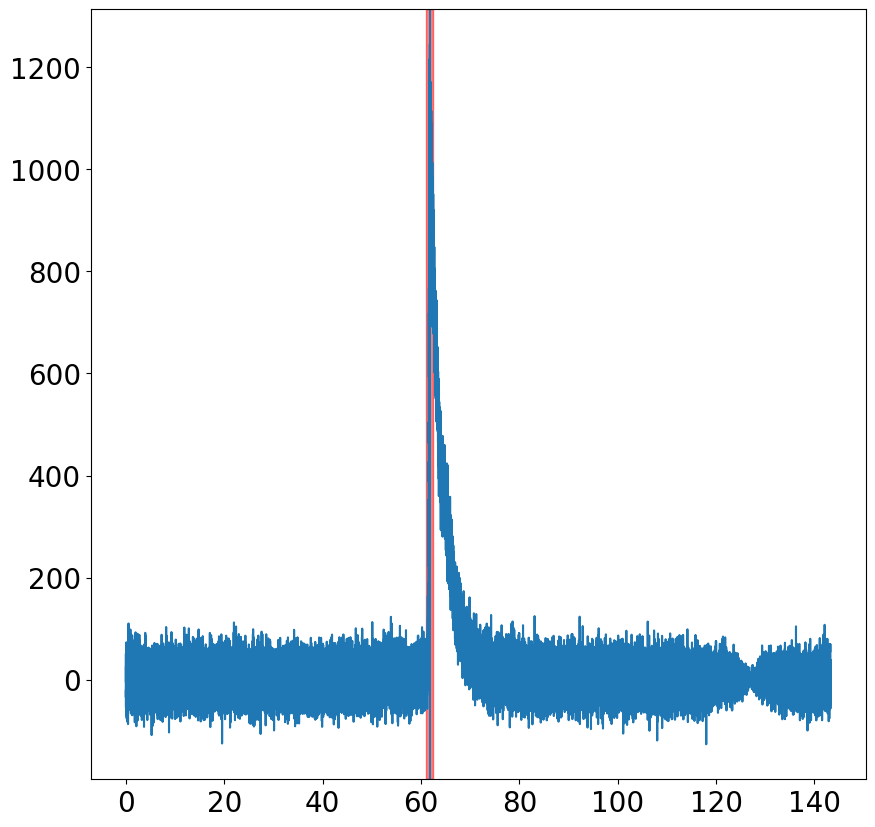

In [74]:
fig = plt.figure()
tsamp = np.linspace(0, (I_t.shape[0])*2.56e-3, I_t.shape[0]) 
plt.plot(tsamp, I_t)
plt.axvspan(peak_idx_chime*2.56e-3 - I_t_fwhm.value, peak_idx_chime*2.56e-3 + I_t_fwhm.value, alpha = 0.5, color='r')
plt.axvline(peak_idx_chime*2.56e-3)
plt.show()

In [80]:
# Burst properties
import numpy as np
from astropy.table import Table

names = np.array([
'zach',
'whitney',
'oran',
'isha',
'wilhelm',
'phineas',
'freya',
'johndoeII',
'hamilton',
'mahi',
'chromatica',
'casey',
])

chimeids = np.array([
'210456524',
'215063905',
'224263996',
'252069198',
'253635173',
'274819243',
'278720455',
'311723353',
'318353610',
'354049284',
'356959136',
'362593221'
])

dir_paths = np.array([
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/02/07/astro_210456524/run_pre_apr2025',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/03/10/astro_215063905',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/05/06/astro_224263996',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/11/13/astro_252069198',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/12/03/astro_253635173',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/03/07/astro_274819243',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/03/25/astro_278720455',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/08/14/astro_311723353',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/09/13/astro_318353610',
'/arc/projects/chime_frb/data/chime/baseband/processed/2024/01/22/astro_354049284',
'/arc/projects/chime_frb/data/chime/baseband/processed/2024/02/03/astro_356959136',
'/arc/projects/chime_frb/data/chime/baseband/processed/2024/02/29/astro_362593221'
])

file_paths = np.array([
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/02/07/astro_210456524/run_pre_apr2025/singlebeam_210456524.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/03/10/astro_215063905/singlebeam_215063905.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/05/06/astro_224263996/singlebeam_224263996.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/11/13/astro_252069198/singlebeam_252069198.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2022/12/03/astro_253635173/singlebeam_253635173.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/03/07/astro_274819243/singlebeam_274819243.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/03/25/astro_278720455/singlebeam_278720455.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/08/14/astro_311723353/singlebeam_311723353.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2023/09/13/astro_318353610/singlebeam_318353610.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2024/01/22/astro_354049284/singlebeam_354049284.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2024/02/03/astro_356959136/singlebeam_356959136.h5',
'/arc/projects/chime_frb/data/chime/baseband/processed/2024/02/29/astro_362593221/singlebeam_362593221.h5'
])

dms_opt = np.array([
262.368,
462.174,
396.882,
411.568,
602.346,
610.274,
912.400,
696.506,
518.799,
960.128,
272.664,
491.207,
])

dsa_mjds = np.array([
59617.808503640170,
59648.241720744330,
59705.597012923540,
59896.386510976576,
59916.001750895850,
60010.378857718510,
60028.071690572535,
60170.360926755560,
60200.207158083010,
60331.104280012750,
60343.831821948540,
60369.370952243030,
])

#dsa_startphases = np.array([
#0.499974144,
#0.49994137600000005,
#0.499646464,
#0.499744768,
#0.499744768,
#0.079888384,
#0.5006295040000001,
#0.49912217600000003,
#0.49984307200000005,
#0.499449856,
#0.499777536,
#0.500006912
#])

time_limits = np.array([
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000],
[0, 10000]
])

rfi_limits = np.array([
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000],
[10000, -10000]
])

fill_wfall_no = np.array([
1,
1,
1,
1,
1,
1,
1,
2,
2,
2,
2,
1
])

localizations = [
    '20h40m47.886s +72d52m56.378s',
    '08h58m52.92s  +73d29m27.0s',
    '21h12m10.760s +72d49m38.20s',
    '04h45m38.64s  +70d18m26.6s',
    '21h00m31.09s  +72d02m15.22s',
    '11h51m07.52s  +71d41m44.3s',
    '05h52m45.12s  +74d12m01.7s',
    '22h23m53.94s +73d01m33.26s',
    '20h20m08.92s +70d47m33.96s',
    '02h39m03.96s +71d01m04.3s',
    '20h50m28.59s +73d54m00.0s',
    '11h19m56.05s +70d40m34.4s'
]


chime_t_unix = np.array([1644261860.9769702, 1646891295.7454515, 1651846791.4170086, 1668331004.4047103, 1670025765.7324185, 1678179947.9440384, 1679708615.9819596, 1692002400.787141, 1694581110.869404, 1705890632.8137624, 1706990275.9132671, 1709196862.0160666]
)

print(len(time_limits), len(rfi_limits), len(fill_wfall_no), len(dsa_mjds), len(file_paths), len(dir_paths), len(dms_opt), len(chimeids), len(names))

# Build the Table
t = Table(
    [names, localizations, chimeids, dir_paths, file_paths,
     dms_opt, chime_t_unix, dsa_mjds, time_limits, rfi_limits, fill_wfall_no],
    names=('name', 'loc','chime_id','dir_path','file_path',
           'dm', 'chime_unix', 'dsa_mjd','time_limits','rfi_limits','fill_wfall_no')
)

# Write to FITS
t.write('bursts.fits', overwrite=True)
print("Written bursts.fits with", len(t), "rows.")

12 12 12 12 12 12 12 12 12
Written bursts.fits with 12 rows.
